In [1]:
import pandas as pd
train = pd.read_pickle("./data/train.pickle")
test = pd.read_pickle("./data/test.pickle")

In [2]:
from sklearn.utils import resample

train_majority = train[train.fraudLabel==0]
train_minority = train[train.fraudLabel==1]

# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Show new class counts
train_upsampled.fraudLabel.value_counts()

1    21036
0    21036
Name: fraudLabel, dtype: int64

In [3]:
X_train = train_upsampled[train_upsampled.columns[1:]]
y_train = train_upsampled["fraudLabel"]
X_test = test[test.columns[1:]]
y_test = test["fraudLabel"]

In [4]:
from sklearn.linear_model import LogisticRegression
logreg_up = LogisticRegression()
logreg_up.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
from sklearn import metrics
test_scores = logreg_up.predict_proba(X_test)
fpr_reg_up, tpr_reg_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_up = metrics.auc(fpr_reg_up, tpr_reg_up)

In [6]:
predictions = pd.read_csv("./data/predictions.csv")
fpr_reg, tpr_reg, _ = metrics.roc_curve(predictions["label"], predictions["predReg"])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ = metrics.roc_curve(predictions["label"], predictions["predGbt"])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

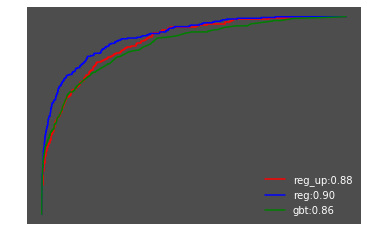

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg_up, tpr_reg_up, color = 'red', label = "reg_up:{:.2f}".format(auc_reg_up))
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# save predictions of upsampled model
predictions['predReg_up'] = test_scores[:,1]
predictions.to_csv("./data/predictions_2.csv", index=False)

### Save predictions on train data for probCalib

In [ ]:
# save predictions to csv
df = pd.read_csv("./data/predictions_train.csv")
df["predReg_up"] = logreg_up.predict_proba(train[train.columns[1:]])[:,1]
df.to_csv("./data/predictions_train_2.csv", index=False)